In [1]:
from plotter_utils import *

# globals
model_name = 'gpt-3.5-turbo-0613'
cpd_dataset_folder = 'datasets/cpd_debates'
cpd_raw_debates_folder = f'{cpd_dataset_folder}/cpd_debates_raw'
cpd_slices_folder = f'{cpd_dataset_folder}/cpd_debates_slices'
cpd_slices_texts_folder = f'{cpd_dataset_folder}/cpd_debates_slices_text'
cpd_measurements_folder = f'{cpd_dataset_folder}/cpd_debates_measurements'
plots_folder = 'plots'
observable_ensemble_plots_folder = f'{plots_folder}/observable_ensemble_plots'
observable_single_vs_multi_speaker_pairplots_folder = f'{plots_folder}/single_vs_multi_speaker_pairplots'
observable_single_vs_multi_speaker_overview_folder = f'{plots_folder}/single_vs_multi_speaker_overview'

report_latex_folder = 'report/sec/code_info/'

debates_d, slices_d, paragraphs_d = load_dataset()
speaker_measurements = load_speaker_measurements()
slice_speaker_base_observables = load_slice_and_measured_observables(slices_d)

In [6]:
def prepare(SS_SSO):
    SS_SSO = prepare_raw_speaker_observables(slice_speaker_base_observables, SS_SSO)

    SS_SSO = transform_str_categories_to_flags(SS_SSO, 'speaker_party')
    SS_SSO = transform_str_categories_to_flags(SS_SSO, 'debate_elected_party')

    SS_SSO = SS_SSO[SS_SSO['speaker_party_is_UNKNOWN'] == 0]
    SS_SSO = SS_SSO.drop(columns=['speaker_party_is_UNKNOWN'])

    return SS_SSO

In [26]:
SS_SSO = prepare(speaker_measurements['WS_SS_SSO_measurements'])

SS_MSOs = {}

for group in multi_speaker_observables_groups:
    SS_MSO = speaker_measurements[f'WS_SS_MSO_{group}_measurements']
    SS_MSOs[group] = prepare(SS_MSO)

SS_MSO = list(SS_MSOs.values())[0].copy()

# only keep slices where f'{slice_id}_{speaker}' is in both dfs
SS_SSO['slice_speaker'] = SS_SSO.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
SS_MSO['slice_speaker'] = SS_MSO.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
SS_SSO = SS_SSO[SS_SSO.slice_speaker.isin(SS_MSO.slice_speaker)]

for SS_MSO in SS_MSOs.values():
    assert(len(SS_SSO) == len(SS_MSO))

score contribution group 1: ['contribution (quality)', 'general score (argue)']
0.62 ± 0.38, 0.91 ± 0.09, 0.72 ± 0.28


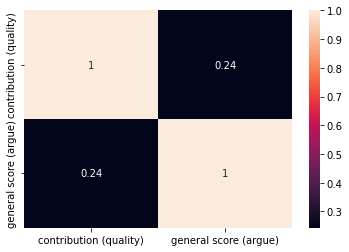

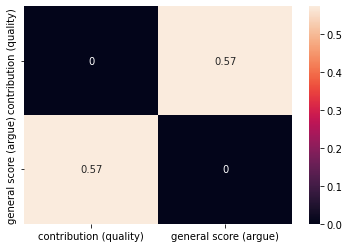

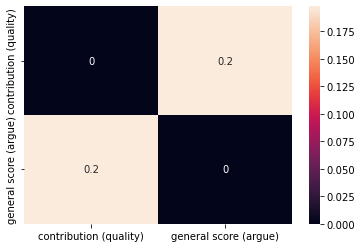

score contribution group 2: ['contribution (quality)', 'general score (argument)']
0.73 ± 0.27, 0.93 ± 0.07, 0.65 ± 0.35


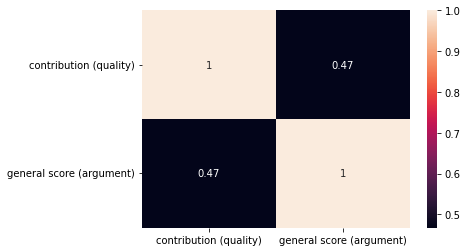

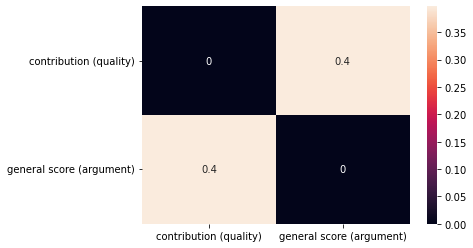

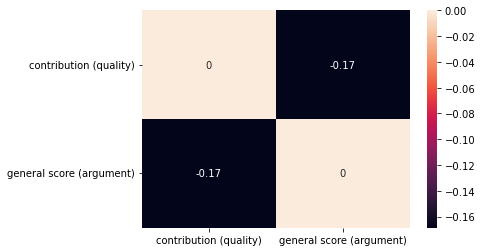

group 1: ['pro democratic (argument)', 'egotistical (benefit)', 'persuasiveness (convincing)', 'clarity (understandable)']
0.25 ± 0.54, 0.32 ± 0.65, 0.27 ± 0.66


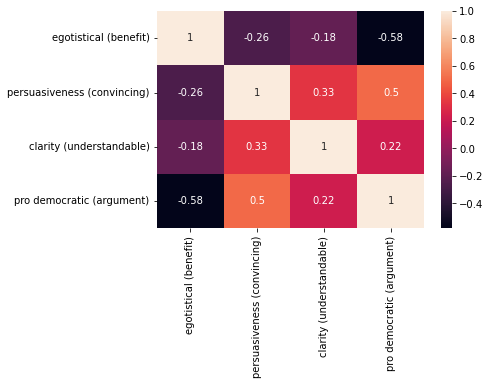

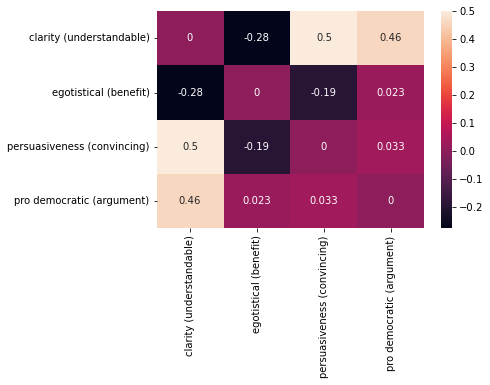

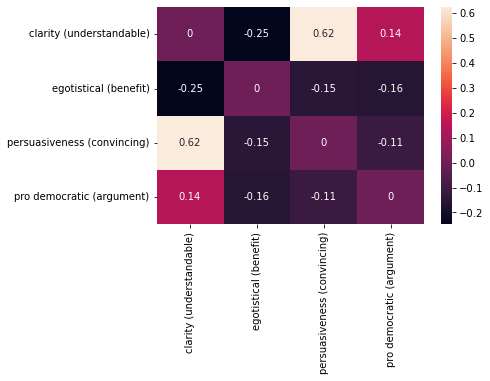

group 2: ['pro republican (argument)', 'persuasiveness (convincing)', 'clarity (easiness)', 'contribution (quality)']
0.32 ± 0.51, 0.52 ± 0.36, 0.31 ± 0.49


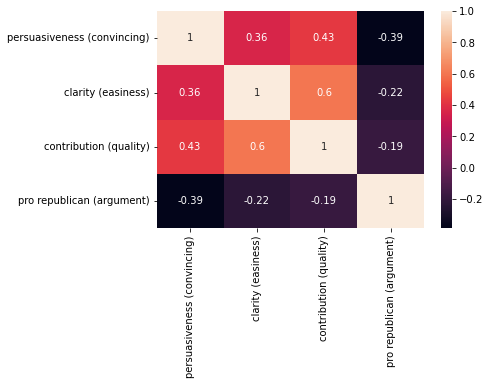

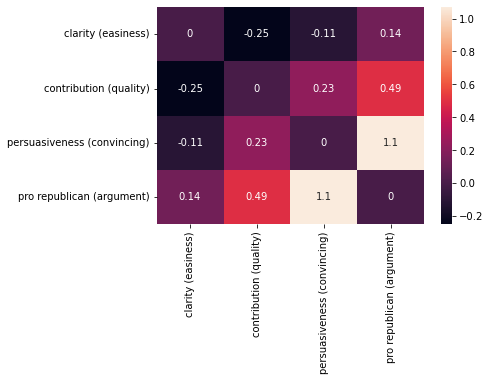

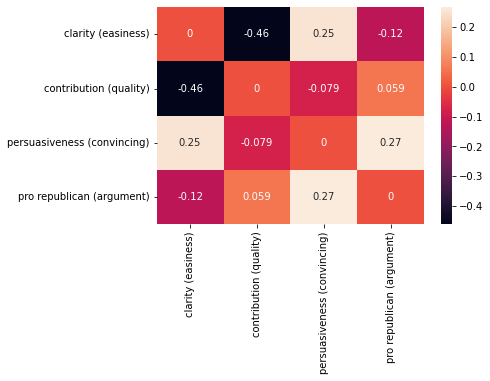

In [31]:
single_group = SS_SSO

for group_name, group in SS_MSOs.items():
    if 'inverse' in group_name:
        continue

    observables = multi_speaker_observables_groups[group_name]
    observables = [o.detailed_name for o in observables]

    print(f'{group_name}: {observables}')

    inverse_group = SS_MSOs[group_name + ' inverse']

    # only keep observables of interest
    single = single_group[single_group.columns.intersection(observables)]
    group = group[group.columns.intersection(observables)]
    inverse_group = inverse_group[inverse_group.columns.intersection(observables)]

    # get internal correlations of each group and for each observable
    corr_single = single.corr()
    corr_group = group.corr()
    corr_inverse_group = inverse_group.corr()

    print(f'{corr_single.values.flatten().mean():.2f} ± {corr_single.values.flatten().std():.2f}, {corr_group.values.flatten().mean():.2f} ± {corr_group.values.flatten().std():.2f}, {corr_inverse_group.values.flatten().mean():.2f} ± {corr_inverse_group.values.flatten().std():.2f}')

    sns.heatmap(corr_single, annot=True)
    plt.show()
    sns.heatmap(corr_group-corr_single, annot=True)
    plt.show()
    sns.heatmap(corr_inverse_group-corr_single, annot=True)
    plt.show()
    # # get correlation by position against single
    # for i in range(len(observables)):
    #     name = observables[i]
    #     group_i = group.iloc[:, i].values
    #     single_i = single[name].values
    #     inverse_group_i = inverse_group.iloc[:, len(observables) - 1 - i].values

    #     print(f'{i}: {name}: {np.corrcoef(group_i, single_i)[0, 1]:.2f}, {np.corrcoef(inverse_group_i, single_i)[0, 1]:.2f}')

    # # get influence of order of observables in each group
    # values_by_pos_single = []
    # values_by_pos_group = []
    # values_by_pos_inverse_group = []
    # for i in range(len(observables)):
    #     # get whole column
    #     values_by_pos_single.append(corr_single.iloc[:, i].values)
    #     values_by_pos_group.append(corr_group.iloc[:, i].values)
    #     values_by_pos_inverse_group.append(corr_inverse_group.iloc[:, i].values)
    
    # values_by_pos_single = np.array(values_by_pos_single)
    # values_by_pos_group = np.array(values_by_pos_group)
    # values_by_pos_inverse_group = np.array(values_by_pos_inverse_group)

    # # get mean and std of each column
    # for i in range(len(observables)):
    #     print(f'row {i}: {values_by_pos_single[i].mean():.2f} ± {values_by_pos_single[i].std():.2f}, {values_by_pos_group[i].mean():.2f} ± {values_by_pos_group[i].std():.2f}, {values_by_pos_inverse_group[i].mean():.2f} ± {values_by_pos_inverse_group[i].std():.2f}')
    
    # # get correlation matrix between positions
    

In [4]:
# compbine dfs
SS_SSO = SS_SSO_grouped_candidates_only_df.copy()
SS_MSO = MS_SSO_grouped_candidates_only_df.copy()

measured_observables = list(speaker_predictor_observables_groups.keys()) + list(speaker_result_observables_groups.keys())

observables_ms_vs_ss = {}
dfs_ms_vs_ss = {}
dfs_slice_internal_ms_vs_ss = {}
for observable in measured_observables:
    std_entries = {}
    slice_internal_entries = {}
    for i, row in SS_MSO.iterrows():
        key = f'{row["slice_id"]}_{row["speaker"]}'
        std_entries[key] = std_entries.get(key, {})
        std_entries[key]['Multiple Speakers'] = row[observable]
        
        key = row['slice_id']
        slice_internal_entries[key] = slice_internal_entries.get(key, {})
        slice_internal_entries[key]['Multiple Speakers'] = slice_internal_entries[key].get('Multiple Speakers', [])
        slice_internal_entries[key]['Multiple Speakers'].append(row[observable])
    for i, row in SS_SSO.iterrows():
        key = f'{row["slice_id"]}_{row["speaker"]}'
        std_entries[key] = std_entries.get(key, {})
        std_entries[key]['Single Speaker'] = row[observable]

        key = row['slice_id']
        slice_internal_entries[key] = slice_internal_entries.get(key, {})
        slice_internal_entries[key]['Single Speaker'] = slice_internal_entries[key].get('Single Speaker', [])
        slice_internal_entries[key]['Single Speaker'].append(row[observable])
    # remove all that don't have both
    std_entries = {k:v for k,v in std_entries.items() if len(v)==2}
    slice_internal_entries = {k:v for k,v in slice_internal_entries.items() if len(v)==2}

    std_entries = [{'index': k, **v} for k,v in std_entries.items()]
    SS_MSO = pd.DataFrame(std_entries)
    SS_MSO = SS_MSO.dropna()
    dfs_ms_vs_ss[observable] = SS_MSO

    e = []
    for key, val in slice_internal_entries.items():
        ssv = val['Single Speaker']
        msv = val['Multiple Speakers']

        e.append({
            'index': key,
            'ss_mean': np.mean(ssv),
            'ss_std': np.std(ssv),
            'ms_mean': np.mean(msv),
            'ms_std': np.std(msv),
            'mean_diff': np.mean(msv)-np.mean(ssv),
            'std_diff': np.std(msv)-np.std(ssv),
        })
    SS_MSO = pd.DataFrame(e)
    SS_MSO.dropna(inplace=True)
    dfs_slice_internal_ms_vs_ss[observable] = SS_MSO

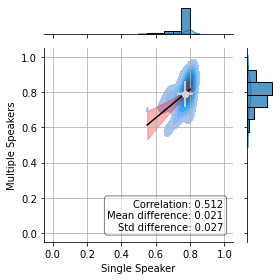

In [5]:
# create pairplot for each ensemble
if not os.path.exists(observable_single_vs_multi_speaker_pairplots_folder):
    os.makedirs(observable_single_vs_multi_speaker_pairplots_folder)

correlations = {}
mean_differences = {}
std_differences = {}

# move score to front
measured_observables.remove('score')
measured_observables.insert(0, 'score')
for observable in measured_observables:
    SS_MSO = dfs_ms_vs_ss[observable]
    # df = pd.DataFrame()
    # df['Single Speaker'] = SS_SSO_grouped_candidates_only_df[observable]
    # df['Multiple Speakers'] = MS_SSO_grouped_candidates_only_df[observable]

    correlations[observable] = SS_MSO['Multiple Speakers'].corr(SS_MSO['Single Speaker'])
    mean_differences[observable] = (SS_MSO['Multiple Speakers'].mean()-SS_MSO['Single Speaker'].mean())
    std_differences[observable] = (SS_MSO['Multiple Speakers'].std()-SS_MSO['Single Speaker'].std())
    # correlations[observable] = df_ss[observable].corr(df_ms[observable])
    # mean_differences[observable] = df_ss[observable].mean()-df_ms[observable].mean()
    # std_differences[observable] = df_ss[observable].std()-df_ms[observable].std()

    # print(f'{observable:<30}\t{correlations[observable]:.3f}')

    # plt.figure(figsize=(5,5))
    # g = sns.kdeplot(x=df['Single Speaker'], y=df['Multiple Speakers']) # TODO: add plots on side
    g = sns.jointplot(x=SS_MSO['Single Speaker'], y=SS_MSO['Multiple Speakers'], kind='kde', fill=True, space=1.0)
    # add grid
    g.fig.axes[0].grid()
    # add xlim and ylim
    g.fig.axes[0].set_xlim(-0.05, 1.05)
    g.fig.axes[0].set_ylim(-0.05, 1.05)
    # set better size for so that text readable
    g.fig.set_size_inches(4, 4)
    # add marginals
    g.plot_marginals(sns.histplot, bins=5) #, kde=True)
    # # Add histogram marginals
    # g.plot_marginals(sns.histplot, color='skyblue')
    # # Add kde marginals
    # g.plot_marginals(sns.kdeplot, color='black', fill=True)

    # add linear regression in black and error band lines in gray
    # ci = 99
    z_score_for_ci_99 = 2.576
    # sns.regplot(x=df['Single Speaker'], y=df['Multiple Speakers'], scatter=False, ax=g.ax_joint, color='black', line_kws={'linewidth': 1}, ci=ci)

    # Perform a linear regression
    x = SS_MSO['Single Speaker']
    y = SS_MSO['Multiple Speakers']

    # Fit the model
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()

    # Predict values
    xp = np.linspace(x.min(), x.max(), 100)
    Xp = sm.add_constant(xp)
    ypred = results.predict(Xp)

    # Get standard deviation of predicted values
    pred_std = results.get_prediction(Xp).se_mean

    # Calculate confidence intervals
    ci_low = ypred - z_score_for_ci_99 * pred_std
    ci_upp = ypred + z_score_for_ci_99 * pred_std

    # Add the regression line and confidence intervals
    g.ax_joint.plot(xp, ypred, color='black')
    g.ax_joint.fill_between(xp, ci_low, ci_upp, color='red', alpha=0.3)

    # add the correlation and the resective means and stds, text in bottom right (not left!)
    text = f'Correlation: {correlations[observable]:.3f}\nMean difference: {mean_differences[observable]:.3f}\nStd difference: {std_differences[observable]:.3f}'
    g.fig.axes[0].text(0.95, 0.05, text, transform=g.fig.axes[0].transAxes, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # add vertical and horizontal lines (lightgray) for the means of both with error bars (black)
    # g.ax_joint.axvline(x=df['Single Speaker'].mean(), color='lightgray', linestyle='--')
    # g.ax_joint.axhline(y=df['Multiple Speakers'].mean(), color='lightgray', linestyle='--')
    g.ax_joint.errorbar(x=SS_MSO['Single Speaker'].mean(), y=SS_MSO['Multiple Speakers'].mean(), xerr=SS_MSO['Single Speaker'].std(), yerr=SS_MSO['Multiple Speakers'].std(), fmt='o', color='lightgray')
    g.ax_joint.errorbar(x=SS_MSO['Single Speaker'].mean(), y=SS_MSO['Multiple Speakers'].mean(), xerr=SS_MSO['Single Speaker'].std(), yerr=SS_MSO['Multiple Speakers'].std(), fmt='o', color='lightgray')



    # g.ax_joint.axvline(x=df['Single Speaker'].mean(), color='black', linestyle='--')
    # g.ax_joint.axhline(y=df['Multiple Speakers'].mean(), color='black', linestyle='--')
    # g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='black')
    # g.ax_joint.errorbar(x=df['Single Speaker'].mean(), y=df['Multiple Speakers'].mean(), xerr=df['Single Speaker'].std(), yerr=df['Multiple Speakers'].std(), fmt='o', color='black')

    # plt.grid()
    # plt.xlim(-0.05, 1.05)
    # plt.ylim(-0.05, 1.05)
    # g = sns.pairplot(df, diag_kind='kde')
    # g.map_upper(sns.regplot)
    # g.map_lower(sns.kdeplot)
    # g.fig.set_size_inches(4, 4)
    # change names of columns
    # for ax in g.axes.flatten():
    #     if ax:
    #         ax.set_xlabel(ax.get_xlabel().split('(')[-1].split(')')[0])
    #         ax.set_ylabel(ax.get_ylabel().split('(')[-1].split(')')[0])

    # make tight layout so that axis is not cut
    plt.tight_layout()
    plt.savefig(f'{observable_single_vs_multi_speaker_pairplots_folder}/{observable}_pairplot.png', dpi=300)
    if observable=='score':
        plt.show()
    plt.close()

0.0013 32.91% 0.1078


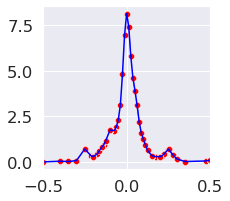

0.0740 54.11% 0.1709


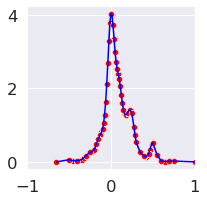

In [6]:
collected_diffs_mean = []
collected_diffs_std = []

for observable in measured_observables:
    SS_MSO = dfs_slice_internal_ms_vs_ss[observable]

    # collected_diffs_mean.append(df['mean_diff'].mean())
    # collected_diffs_std.append(df['std_diff'].mean())

    # normalize std diffs
    std_diffs = SS_MSO['std_diff'].to_numpy()
    # std_diffs = std_diffs - std_diffs.mean()
    for std_diff in std_diffs:
        collected_diffs_std.append(std_diff)

    # normalize mean diffs
    mean_diffs = SS_MSO['mean_diff'].to_numpy()
    # mean_diffs = mean_diffs - mean_diffs.mean()
    for mean_diff in mean_diffs:
        collected_diffs_mean.append(mean_diff)

# sns.histplot(collected_diffs_std, bins=10, legend=False) #, kde=True)
# plt.show()

def plot_kde_with_points(x):
    from scipy.stats import gaussian_kde

    # Compute KDE
    kde = gaussian_kde(x)

    # Evaluate the KDE on the grid
    y = kde.evaluate(x)

    # increase the font size
    sns.set(font_scale=1.5)
    # Plot KDE curve
    plt.figure(figsize=(3,3))
    # get max of abs of x
    max_x = max(abs(min(x)), abs(max(x)))
    plt.xlim(-max_x, max_x)
    sns.lineplot(x=x, y=y, color='blue')

    # Plot the actual data points on the KDE curve
    sns.scatterplot(x=x, y=y, color='red')

    # sns grid
    sns.set_style("whitegrid")
    # plt.grid()

if not os.path.exists(observable_single_vs_multi_speaker_overview_folder):
    os.makedirs(observable_single_vs_multi_speaker_overview_folder)

percentage_bigger = np.sum(np.array(collected_diffs_std) > 0) / len(collected_diffs_std) * 100
print(f'{np.mean(collected_diffs_std):.4f} {percentage_bigger:.2f}% {np.std(collected_diffs_std):.4f}')
plot_kde_with_points(collected_diffs_std)
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/internal_ms_minus_ss_std_kde.png', dpi=300)
plt.show()
percentage_bigger = np.sum(np.array(collected_diffs_mean) > 0) / len(collected_diffs_mean) * 100
print(f'{np.mean(collected_diffs_mean):.4f} {percentage_bigger:.2f}% {np.std(collected_diffs_mean):.4f}')
plot_kde_with_points(collected_diffs_mean)
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/internal_ms_minus_ss_mean_kde.png', dpi=300)
plt.show()

In [7]:
# # visualize slice internal differences
# for observable in measured_observables:
#     print(observable)
#     df = dfs_slice_internal_ms_vs_ss[observable]

#     sns.pairplot(df, vars=['ss_mean', 'ms_mean'])
#     plt.show()
#     sns.pairplot(df, vars=['ss_std', 'ms_std'])
#     plt.show()
#     # sns.catplot(df, x=['ss_mean', 'ms_mean', 'ss_std', 'ms_std'])
#     sns.histplot(df['mean_diff'])
#     plt.show()
#     sns.histplot(df['std_diff'])
#     plt.show()
#     sns.histplot(df[['ss_mean', 'ms_mean']])
#     plt.show()
#     sns.histplot(df[['ss_std', 'ms_std']])
#     plt.show()

#     break

std
0.0152 69.70% 0.0456


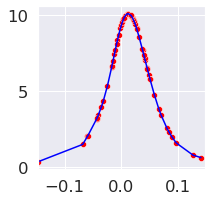

mean
0.0740 83.33% 0.0852


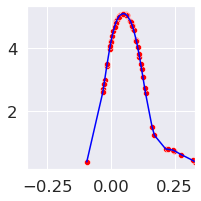

In [8]:
# histogram of variance and mean for multi and single

ms_stds = []
ss_stds = []
ms_means = []
ss_means = []

std_entries = []
mean_entries = []
for observable in measured_observables:
    SS_MSO = dfs_ms_vs_ss[observable]
    ms_stds.append(SS_MSO['Multiple Speakers'].std())
    ss_stds.append(SS_MSO['Single Speaker'].std())
    ms_means.append(SS_MSO['Multiple Speakers'].mean())
    ss_means.append(SS_MSO['Single Speaker'].mean())

    std_entries.append({
        'Multiple Speakers': SS_MSO['Multiple Speakers'].std(),
        'Single Speaker': SS_MSO['Single Speaker'].std(),
    })

    mean_entries.append({
        'Multiple Speakers': SS_MSO['Multiple Speakers'].mean(),
        'Single Speaker': SS_MSO['Single Speaker'].mean(),
    })

std_df = pd.DataFrame(std_entries)
mean_df = pd.DataFrame(mean_entries)
# print(std_df.mean())
# print(mean_df.mean())
# sns.histplot(std_df) #, multiple='dodge', bins=5)
# plt.show()
# sns.histplot(mean_df) #, multiple='dodge', bins=5)
# plt.show()

print('std')
std_diff = std_df['Multiple Speakers']-std_df['Single Speaker']
percentage_bigger = (std_diff > 0).sum() / len(std_diff) * 100
print(f'{std_diff.mean():.4f} {percentage_bigger:.2f}% {std_diff.std():.4f}')
plot_kde_with_points(std_df['Multiple Speakers']-std_df['Single Speaker'])
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/external_ms_minus_ss_std_kde.png', dpi=300)
plt.show()
print('mean')
mean_diff = mean_df['Multiple Speakers']-mean_df['Single Speaker']
percentage_bigger = (mean_diff > 0).sum() / len(mean_diff) * 100
print(f'{mean_diff.mean():.4f} {percentage_bigger:.2f}% {mean_diff.std():.4f}')
plot_kde_with_points(mean_df['Multiple Speakers']-mean_df['Single Speaker'])
plt.savefig(f'{observable_single_vs_multi_speaker_overview_folder}/external_ms_minus_ss_mean_kde.png', dpi=300)
plt.show()

In [18]:
SS_SSO = SS_SSO_grouped_candidates_only_df.copy()
SS_MSO = MS_SSO_grouped_candidates_only_df.copy()
print(len(SS_SSO), len(SS_MSO))

# only keep slices where f'{slice_id}_{speaker}' is in both dfs
SS_SSO['slice_speaker'] = SS_SSO.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
SS_MSO['slice_speaker'] = SS_MSO.apply(lambda x: f'{x.slice_id}_{x.speaker}', axis=1)
SS_SSO = SS_SSO[SS_SSO.slice_speaker.isin(SS_MSO.slice_speaker)]
SS_MSO = SS_MSO[SS_MSO.slice_speaker.isin(SS_SSO.slice_speaker)]

print(len(SS_SSO), len(SS_MSO))

156 97
97 97


In [33]:
corr_ss = SS_SSO.corr()
corr_ms = SS_MSO.corr()
corr_ss.dropna(axis=0, inplace=True, how='all')
corr_ss.dropna(axis=1, inplace=True, how='all')
corr_ms.dropna(axis=0, inplace=True, how='all')
corr_ms.dropna(axis=1, inplace=True, how='all')

flat = corr_ss.abs().values.flatten()
print(flat.mean(), flat.std())

0.22830895950077962 0.18779877881667115


In [16]:
for i in range(2, 90):
    if (i>10 and i%10!=0) or i%2!=0:
        continue

    corr_ss = kfold_cross_validation(SS_SSO, lambda x: x.corr(), lambda x: x.var(), n_splits=i, iterations=500//i)
    corr_ms = kfold_cross_validation(SS_MSO, lambda x: x.corr(), lambda x: x.var(), n_splits=i, iterations=500//i)
    corr_ss.dropna(axis=0, inplace=True, how='all')
    corr_ss.dropna(axis=1, inplace=True, how='all')
    corr_ms.dropna(axis=0, inplace=True, how='all')
    corr_ms.dropna(axis=1, inplace=True, how='all')

    m_ss = corr_ss.mean().mean()
    m_ms = corr_ms.mean().mean()
    print(f'{i} folds: {m_ss:.5f} vs {m_ms:.5f} (ss to ms ratio {m_ss/m_ms:.5f})')

156 97
97 97
2 folds: 0.00958 vs 0.01010 (ss to ms ratio 0.94855)
4 folds: 0.00329 vs 0.00340 (ss to ms ratio 0.96767)
6 folds: 0.00195 vs 0.00203 (ss to ms ratio 0.95781)
8 folds: 0.00138 vs 0.00143 (ss to ms ratio 0.96307)
10 folds: 0.00108 vs 0.00112 (ss to ms ratio 0.96381)
20 folds: 0.00051 vs 0.00053 (ss to ms ratio 0.95433)
30 folds: 0.00034 vs 0.00035 (ss to ms ratio 0.97205)
40 folds: 0.00025 vs 0.00026 (ss to ms ratio 0.97707)
50 folds: 0.00020 vs 0.00021 (ss to ms ratio 0.96852)
60 folds: 0.00017 vs 0.00017 (ss to ms ratio 0.96952)
70 folds: 0.00014 vs 0.00015 (ss to ms ratio 0.96661)
80 folds: 0.00012 vs 0.00013 (ss to ms ratio 0.97136)


In [10]:
# correlations_s = dict(sorted(correlations.items(), key=lambda x: x[1], reverse=True))
# for key in correlations_s:
#     print(f'{key:<35}:\tCor={correlations_s[key]:.3f}\tMean Diff={mean_differences[key]:.3f}   \tMean Std={std_differences[key]:.3f}')

In [11]:
# mean_differences_s = dict(sorted(mean_differences.items(), key=lambda x: x[1], reverse=True))
# for key in mean_differences_s:
#     print(f'{key:<35}:\tCor={correlations[key]:.3f}\tMean Diff={mean_differences[key]:.3f}   \tMean Std={std_differences[key]:.3f}')

In [12]:
# print differences of std within single query


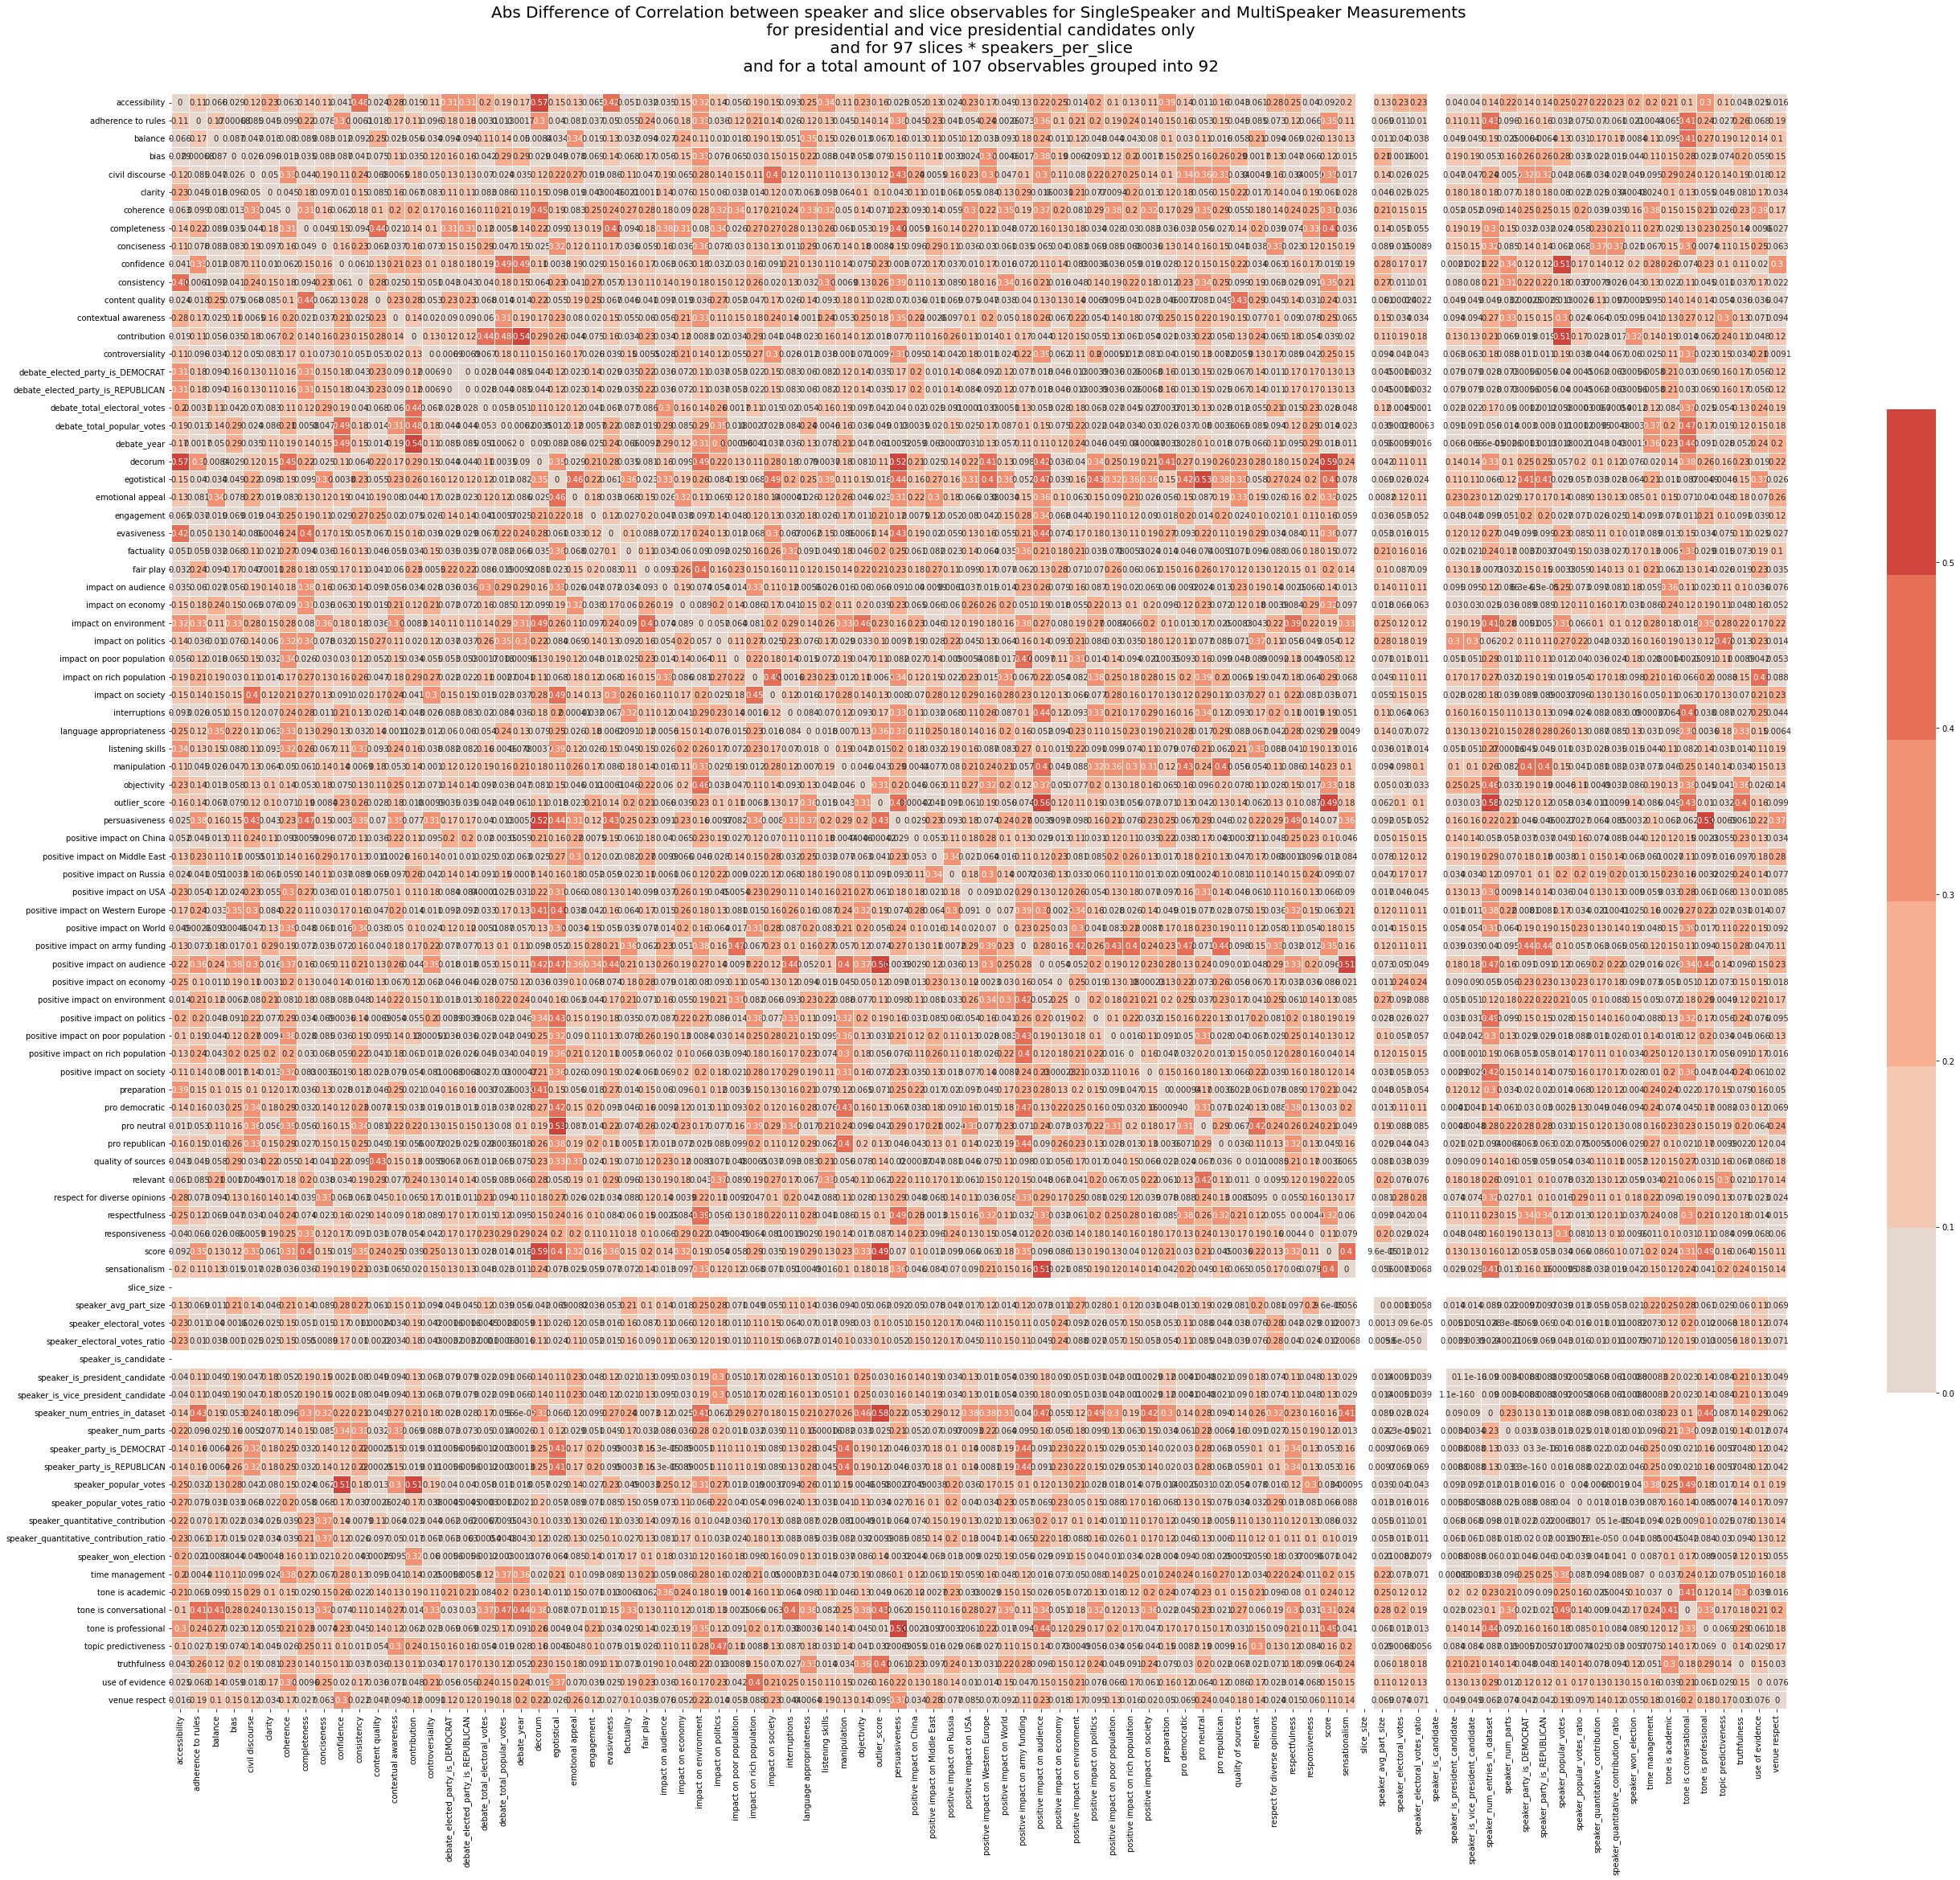

In [ ]:
# mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(45, 45))
# create color map between -1 and 1 for heatmap that is dark blue for -1, light blue for -0.5, white for 0, light red for 0.5, dark red for 1
# create color map where the gradient changes faster if there are more values in a bin
cmap = sns.color_palette("coolwarm", 12)

MS_SSO_corr = MS_SSO_corr
# abs of difference between SS_SSO_corr and MS_SSO_corr
data = np.abs(SS_SSO_corr-MS_SSO_corr)
sns.heatmap(data, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title(f'Abs Difference of Correlation between speaker and slice observables for SingleSpeaker and MultiSpeaker Measurements\n \
for presidential and vice presidential candidates only\n \
and for {len(MS_SSO_grouped_candidates_only_df)} slices * speakers_per_slice\n \
and for a total amount of {n_raw_observables} observables grouped into {n_grouped_observables}\n', fontsize=20)
plt.show()